# Multilayer Perceptrons with scikit-learn

**XBUS-512: Introduction to AI and Deep Learning**

In this exercise, we will see how to build a preliminary neural model using the familiar scikit-learn library. While scikit-learn is not a deep learning library, it does provide basic implementations of the multilayer perceptron (MLP) for both classification and regression.


Thanks to [this team](https://github.com/Wall-eSociety/CommentVolumeML) for figuring out the labels for this dataset!

## Imports

In [1]:
import os
import time
import zipfile
import requests
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split as tts
from sklearn.neural_network import MLPClassifier, MLPRegressor
from yellowbrick.regressor import PredictionError, ResidualsPlot

## Download the data

In [2]:
def fetch_data(url, fname):
    """
    Helper method to retreive the data from the UCI ML Repository.
    """
    response = requests.get(url)
    outpath  = os.path.abspath(fname)
    with open(outpath, "wb") as f:
        f.write(response.content)
    
    return outpath

In [3]:
# Fetch and unzip the data

URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00363/Dataset.zip"
ZIPPED_FILES = "facebook_data.zip"
UNZIPPED_FILES = "facebook_data"

zipped_data = fetch_data(URL, os.path.join("../fixtures", ZIPPED_FILES))

with zipfile.ZipFile(os.path.join("../fixtures", ZIPPED_FILES), "r") as zfiles:
    zfiles.extractall(os.path.join("../fixtures", UNZIPPED_FILES))

In [4]:
data = pd.read_csv(
    os.path.join(
        "../fixtures", 
        UNZIPPED_FILES, 
        "Dataset", 
        "Training", 
        "Features_Variant_2.csv"
    ),
    header=None
)
data.columns = [
    "likes", "views", "returns", "category", "derived_1", "derived_2", "derived_3",
    "derived_4", "derived_5", "derived_6", "derived_7", "derived_8", "derived_9",
    "derived_10", "derived_11", "derived_12", "derived_13", "derived_14", "derived_15", 
    "derived_16", "derived_17", "derived_18", "derived_19", "derived_20", "derived_21",
    "derived_22", "derived_23", "derived_24", "derived_25", "cc_1", "cc_2", "cc_3",
    "cc_4", "cc_5", "base_time", "length", "shares", "status", "h_local", "sunday_post",
    "monday_post", "tuesday_post", "wednesday_post", "thursday_post", "friday_post",
    "saturday_post", "sunday_base", "monday_base", "tuesday_base", "wednesday_base",
    "thursday_base", "friday_base", "saturday_base", "target"
]

data.describe()

,likes,views,returns,category,derived_1,derived_2,derived_3,derived_4,derived_5,derived_6,...,friday_post,saturday_post,sunday_base,monday_base,tuesday_base,wednesday_base,thursday_base,friday_base,saturday_base,target
count,8.131200e+04,81312.000000,8.131200e+04,81312.000000,81312.000000,81312.000000,81312.000000,81312.000000,81312.000000,81312.000000,...,81312.000000,81312.000000,81312.000000,81312.000000,81312.000000,81312.000000,81312.000000,81312.000000,81312.000000,81312.000000
mean,1.313921e+06,4667.704336,4.475377e+04,24.255633,0.707190,464.665781,55.728933,35.392255,67.588653,0.143361,...,0.146153,0.136954,0.141049,0.133400,0.138417,0.145477,0.155180,0.144997,0.141480,7.190611
std,6.804951e+06,20561.261034,1.109279e+05,19.949156,12.169748,520.925523,85.243275,67.043844,82.836764,7.819979,...,0.353262,0.343801,0.348075,0.340008,0.345340,0.352583,0.362078,0.352100,0.348518,36.049374
min,3.600000e+01,0.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.673400e+04,0.000000,6.980000e+02,9.000000,0.000000,47.000000,5.190751,2.000000,8.032349,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.929110e+05,0.000000,7.045000e+03,18.000000,0.000000,251.000000,22.794183,13.000000,32.565168,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.204214e+06,99.000000,5.026400e+04,32.000000,0.000000,717.000000,71.791489,42.000000,102.060861,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,4.869723e+08,186370.000000,6.089942e+06,106.000000,1311.000000,2438.000000,1693.500000,1693.500000,743.091650,1311.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1966.000000


In [5]:
def prepare_for_regression(dataframe):
    """
    Prepare the data for a regression problem where we will attempt
    to regress the number of comments that a Facebook post will get
    given other features of the data.
    
    Returns a tuple containing an nd array of features (X)
    and a 1d array for the target (y)
    """
    features = [
        "likes", "views", "returns", "category", "derived_1", "derived_2", "derived_3",
        "derived_4", "derived_5", "derived_6", "derived_7", "derived_8", "derived_9",
        "derived_10", "derived_11", "derived_12", "derived_13", "derived_14", "derived_15", 
        "derived_16", "derived_17", "derived_18", "derived_19", "derived_20", "derived_21",
        "derived_22", "derived_23", "derived_24", "derived_25", "cc_1", "cc_2", "cc_3",
        "cc_4", "cc_5", "base_time", "length", "shares", "status", "h_local", "sunday_post",
        "monday_post", "tuesday_post", "wednesday_post", "thursday_post", "friday_post",
        "saturday_post", "sunday_base", "monday_base", "tuesday_base", "wednesday_base",
        "thursday_base", "friday_base", "saturday_base"     
    ]
    target = "target"
    
    # MLP is sensitive to feature scaling!
    X = MinMaxScaler().fit_transform(dataframe[features].values)
    y = dataframe[target].values
    
    return X, y


def prepare_for_classification(dataframe):
    """
    Prepare the data for a classification problem where we will attempt
    to predict the category of a Facebook post given features of the data.
    
    Returns a tuple containing an nd array of features (X)
    and a 1d array for the target (y)
    """
    features = [
        "likes", "views", "returns", "derived_1", "derived_2", "derived_3",
        "derived_4", "derived_5", "derived_6", "derived_7", "derived_8", "derived_9",
        "derived_10", "derived_11", "derived_12", "derived_13", "derived_14", "derived_15", 
        "derived_16", "derived_17", "derived_18", "derived_19", "derived_20", "derived_21",
        "derived_22", "derived_23", "derived_24", "derived_25", "cc_1", "cc_2", "cc_3",
        "cc_4", "cc_5", "base_time", "length", "shares", "status", "h_local", "sunday_post",
        "monday_post", "tuesday_post", "wednesday_post", "thursday_post", "friday_post",
        "saturday_post", "sunday_base", "monday_base", "tuesday_base", "wednesday_base",
        "thursday_base", "friday_base", "saturday_base", "target"     
    ]
    target = "category"
    
    # MLP is sensitive to feature scaling!
    X = MinMaxScaler().fit_transform(dataframe[features].values)
    y = dataframe[target].values
    
    return X, y

In [6]:
# Prepare the data and break in to training and test splits
X, y = prepare_for_regression(data)
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=42)

## Instantiate the model, set hyperparameters, and train

In [7]:
start = time.time()

model = MLPRegressor(
    hidden_layer_sizes=(100, 50, 25), 
    activation="relu",
    solver="adam",
    batch_size=2,
    max_iter=100,
    verbose=True
)
model.fit(X_train, y_train)

print("Training took {} seconds".format(
    time.time() - start
))

Iteration 1, loss = 389.52672201
Iteration 2, loss = 340.32386873
Iteration 3, loss = 314.30696870
Iteration 4, loss = 306.93570035
Iteration 5, loss = 291.17694831
Iteration 6, loss = 285.19747215
Iteration 7, loss = 276.60965611
Iteration 8, loss = 267.86736186
Iteration 9, loss = 260.18066323
Iteration 10, loss = 269.53609003
Iteration 11, loss = 260.04264600
Iteration 12, loss = 247.49019041
Iteration 13, loss = 249.41138595
Iteration 14, loss = 246.09016510
Iteration 15, loss = 247.39640915
Iteration 16, loss = 234.54866974
Iteration 17, loss = 245.65042603
Iteration 18, loss = 241.88881195
Iteration 19, loss = 234.66269036
Iteration 20, loss = 231.91077631
Iteration 21, loss = 235.67317134
Iteration 22, loss = 235.39631532
Iteration 23, loss = 223.57736947
Iteration 24, loss = 227.85453371
Iteration 25, loss = 224.04056516
Iteration 26, loss = 213.87969028
Iteration 27, loss = 215.38052546
Iteration 28, loss = 217.54964180
Iteration 29, loss = 215.96802779
Iteration 30, loss = 21

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [8]:
pred_train = model.predict(X_train)
print("Training error: {}".format(
    np.sqrt(mean_squared_error(y_train, pred_train))
))

pred = model.predict(X_test)
print("Test error: {}".format(
    np.sqrt(mean_squared_error(y_test, pred))
))

Training error: 17.250421229079134
Test error: 22.806257995255756


## Visualize the results using Yellowbrick

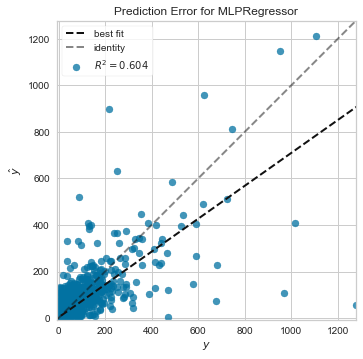

In [9]:
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()  

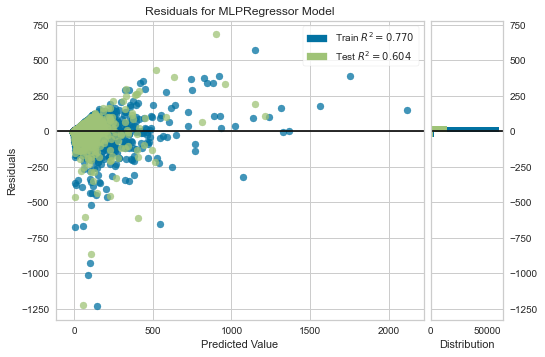

In [10]:
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()  

## Tune the hyperparameters

## Pickle the model

## Restore the model and run live predictions

## Takeaways from our scikit-learn prototype:
    - sklearn API is convenient
    - can tune some hyperparams
    - easy to visualize & diagnose with Yellowbrick
    - tough to tune for overfit model... would be nice to have dropout, for instance
    - sloooooow
    